In [147]:
#-*-coding:utf-8-*-
import pandas as pd
import numpy as np
from pandas import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
import tensorflow as tf
from datetime import timedelta
import autokeras as ak
from kerastuner import HyperModel
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from datetime import timedelta
import math
import keras
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import save_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from pickle import dump,load
import warnings
warnings.simplefilter("ignore", UserWarning)
# from hyperopt import Trials, STATUS_OK, tpe, fmin, hp

#만든 모듈을 불러옴
import sys
from importlib import reload
sys.path.append('C:/Users/USER/Documents/GitHub/Time_Series_models/Demand_predict/') 
print(sys.path)
import LSTM_module as tsm


['c:\\Users\\USER\\Documents\\GitHub\\Time_Series_models\\Demand_predict', 'c:\\Users\\USER\\AppData\\Local\\Programs\\Python\\Python39\\python39.zip', 'c:\\Users\\USER\\AppData\\Local\\Programs\\Python\\Python39\\DLLs', 'c:\\Users\\USER\\AppData\\Local\\Programs\\Python\\Python39\\lib', 'c:\\Users\\USER\\AppData\\Local\\Programs\\Python\\Python39', '', 'c:\\Users\\USER\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages', 'c:\\Users\\USER\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\win32', 'c:\\Users\\USER\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\win32\\lib', 'c:\\Users\\USER\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\Pythonwin', 'C:/Users/USER/Documents/GitHub/Time_Series_models/Demand_predict/', 'C:/Users/USER/Documents/GitHub/Time_Series_models/Demand_predict/', 'C:/Users/USER/Documents/GitHub/Time_Series_models/Demand_predict/', 'C:/Users/USER/Documents/GitHub/Time_Series_models/Demand_predict/', 'C:/Us

C:\Users\USER\AppData\Local\Temp\ipykernel_7364\872417664.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [148]:
data=pd.read_excel('C:/Users/USER/Desktop/진행중/FEMS/datamart/무림페이퍼_15분사용전력_210401-220630.xlsx')
data.columns
data=data.drop(['등록시각'],axis=1)
data['기준시각']=pd.to_datetime(data['기준시각'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42766 entries, 0 to 42765
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   기준시각         42766 non-null  datetime64[ns]
 1   직전 15분 사용전력  42766 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 668.3 KB


In [149]:
#train_test split
def train_test_split(data_t,train_cut_date,val_cut_date): 
  
    df_train = data_t[data_t['기준시각'] < train_cut_date ]
    df_val= data_t[(data_t['기준시각'] >= train_cut_date ) & (data_t['기준시각'] < val_cut_date )]
    df_test = data_t[(data_t['기준시각'] >= val_cut_date)] 
    
    return (df_train,df_val,df_test) 

df_train,df_val,df_test=train_test_split(data,'2022-06-01','2022-06-30')
print('train_df=',min(df_train['기준시각']),'~',max(df_train['기준시각']),',',len(df_train))
print('val_df=',min(df_val['기준시각']),'~',max(df_val['기준시각']),',',len(df_val))
print('test_df=',min(df_test['기준시각']),'~',max(df_test['기준시각']),',',len(df_test))

train_df= 2021-04-01 00:00:00 ~ 2022-05-31 23:45:00 , 39886
val_df= 2022-06-01 00:00:00 ~ 2022-06-29 23:45:00 , 2784
test_df= 2022-06-30 00:00:00 ~ 2022-06-30 23:45:00 , 96


In [150]:
# dateaframe to tensor
nd=np.asarray(df_train['직전 15분 사용전력'])
ndd=nd.reshape(len(df_train),)

nv=np.asarray(df_val['직전 15분 사용전력'])
nvv=nv.reshape(len(df_val),)

nt=np.asarray(df_test['직전 15분 사용전력'])
ntt=nt.reshape(len(df_test),)

In [151]:
n_steps = 300
(train_x, train_y) = tsm.split_sequence(ndd, n_steps) 
print(train_x.shape) 
print(train_y.shape)
(val_x, val_y) = tsm.split_sequence(nvv, n_steps) 
print(val_x.shape) 
print(val_y.shape)
(test_x, test_y) = tsm.split_sequence(ntt, n_steps) 
print(test_x.shape) 
print(test_y.shape)

(39586, 300)
(39586,)
(2484, 300)
(2484,)
(0,)
(0,)


In [154]:
n_features = 1
train_x = train_x.reshape(train_x.shape[0], n_steps, n_features)
val_x = val_x.reshape(val_x.shape[0], n_steps, n_features)

print(train_x.shape)
print(val_x.shape) 

(39586, 300, 1)
(2484, 300, 1)


In [142]:
# train(train,val)
# Hyperparameter Setting
BATCH_SIZE = 32
BUFFER_SIZE=100

# # Dataset -> Tensor
train_univariate = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((val_x, val_y))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

###  Autokeras

In [65]:
import tensorflow as tf
import autokeras as ak

In [97]:
predict_from = 30
predict_until = 10
lookback = 3
clf = ak.TimeseriesForecaster(
    lookback=lookback,
    predict_from=predict_from,
    predict_until=predict_until,
    max_trials=1,
    objective="val_loss",
)
# Train the TimeSeriesForecaster with train data
model=clf.fit(
    x=train_x,
    y=train_y,
    validation_data=(val_x, val_y),
    batch_size=32,
    epochs=10,
)


INFO:tensorflow:Reloading Oracle from existing project .\time_series_forecaster\oracle.json


INFO:tensorflow:Reloading Oracle from existing project .\time_series_forecaster\oracle.json


INFO:tensorflow:Reloading Tuner from .\time_series_forecaster\tuner0.json


INFO:tensorflow:Reloading Tuner from .\time_series_forecaster\tuner0.json


INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Epoch 1/10
1247/1247 [==============================] - 11s 7ms/step - loss: 48796276.0000 - mean_squared_error: 48796276.0000 - val_loss: 47664604.0000 - val_mean_squared_error: 47664604.0000
Epoch 2/10
1247/1247 [==============================] - 7s 6ms/step - loss: 48416108.0000 - mean_squared_error: 48416108.0000 - val_loss: 47314188.0000 - val_mean_squared_error: 47314188.0000
Epoch 3/10
1247/1247 [==============================] - 7s 6ms/step - loss: 48068628.0000 - mean_squared_error: 48068628.0000 - val_loss: 46970412.0000 - val_mean_squared_error: 46970412.0000
Epoch 4/10
1247/1247 [==============================] - 7s 6ms/step - loss: 47721208.0000 - mean_squared_error: 47721208.0000 - val_loss: 46628528.0000 - val_mean_squared_error: 46628528.0000
Epoch 5/10
1247/1247 [==============================] - 7s 6ms/step - loss: 47379200.0000 - mean_squared_error: 47379200.0000 - val_loss: 46288756.0000 - val_mean_squared_error: 46288756.0000
Epoch 6/10
1247/1247 [=================

INFO:tensorflow:Assets written to: .\time_series_forecaster\best_model\assets


INFO:tensorflow:Assets written to: .\time_series_forecaster\best_model\assets


In [101]:
# Predict with the best model(includes original training data).
predictions = clf.predict(train_x)
print(predictions.shape)
# Evaluate the best model with testing data.
print(clf.evaluate(test_x, test_y))

1247/1247 [==============================] - 7s 5ms/step
(0, 1)
3/3 [==============================] - 1s 12ms/step - loss: 32334866.0000 - mean_squared_error: 32334866.0000
[32334866.0, 32334866.0]


### LSTM

In [104]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.models import load_model

In [143]:
path_checkpoint = "lstm_model_checkpoint_try4.h5"
es_callback = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=0, patience=100, mode='auto')# mode=auto loss면 최저값100번정도 반복되면 정지, acc면 최고값이 100번정도 반복되면 정지

modelckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    monitor="loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,)

In [144]:
# Build Simple LSTM Model
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(10, activation = 'relu', input_shape=(n_steps,1),return_sequences=True),#
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(20, activation = 'relu', input_shape=(n_steps,1),return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(10, activation = 'relu', input_shape=(n_steps,1)), 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5),   
    tf.keras.layers.Dense(1)
])


simple_lstm_model.compile(optimizer='adam', loss='mse',metrics=['mse'])

##


In [ ]:
# def split_data(df,train_size):
#     train_days=math.floor(len(df)*train_size/24)
#     train_data,test_data=df.iloc[0:train_days*24],df.iloc[train_days*24:len(df)]
#     return train_data,test_data

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32),return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32)))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(Y_train.shape[1], activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])
    return model

scaler, kerastuner

In [145]:
# Train the Model(val)
EVALUATION_INTERVAL = 100
EPOCHS = 1000

history=simple_lstm_model.fit(train_univariate , epochs=EPOCHS,validation_data=val_univariate,steps_per_epoch=EVALUATION_INTERVAL,validation_steps=1,verbose=1,callbacks=[es_callback, modelckpt_callback])

Epoch 1/1000
100/100 [==============================] - ETA: 0s - loss: nan - mse: nan
Epoch 1: loss did not improve from inf
100/100 [==============================] - 24s 224ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 2/1000
100/100 [==============================] - ETA: 0s - loss: nan - mse: nan
Epoch 2: loss did not improve from inf
100/100 [==============================] - 24s 242ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 3/1000
100/100 [==============================] - ETA: 0s - loss: nan - mse: nan
Epoch 3: loss did not improve from inf
100/100 [==============================] - 24s 241ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 4/1000
100/100 [==============================] - ETA: 0s - loss: nan - mse: nan
Epoch 4: loss did not improve from inf
100/100 [==============================] - 24s 244ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 5/1000
100/100 [==========================

KeyboardInterrupt: 

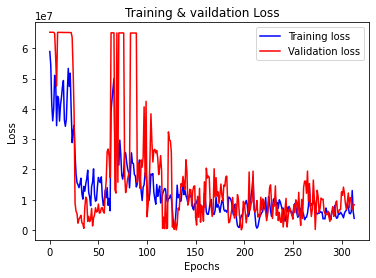

In [ ]:
tsm.visualize_loss(history, "Training & vaildation Loss",'C:/Users/USER/Desktop/진행중/FEMS/moorim/')

In [136]:
yhat = simple_lstm_model.predict(test_x)
prediction=pd.DataFrame(yhat)
prediction.columns=['yhat']
# prediction.index=df_test[4:].index   # index 설정방법
# df_test=df_test.reset_index()
prediction=prediction.reset_index()
prediction['y']=df_test['직전 15분 사용전력']
prediction['time']=df_test['기준시각']



3/3 [==============================] - 0s 5ms/step


In [137]:
plt.figure(figsize=(30,20))
kws = dict(marker='o')
plt.plot(train['기준시각'],train['직전 15분 사용전력'], label='Train', **kws)   
plt.plot(test['기준시각'],test['직전 15분 사용전력'], label='Test', **kws)   
plt.plot(prediction['time'],prediction['yhat'],label='predicted', **kws)
plt.legend()
plt.show()

In [ ]:
from kerastuner.tuners import BayesianOptimization